# Fitting with Radial Basis Functions (8 points)

## Due date is posted on Canvas. Projects are accepted late with a 15% per day penalty, pro-rated hourly. If you are 30 hours late, your penalty is (30/24)*15%. 

## Introduction

In HW and lecture, you used linear regression to fit monomials, a set of nonlinear basis functions, to a set of points in 3D (surface regression). In Project 2, we will explore a special nonlinear basis called the **radial basis functions** and see how these functions can be used to better fit a surface to a set of ponts. If you have heard of Machine Learning, a popular form of AI, then you'll be happy to know that radial basis functions are very common in Supervised Machine Learning!

**Note:** As you walk through the notebook, if there is a cell that contains code or a step that you don't quite understand, feel free to create a new block right below the cell and type $\texttt{@show}$ $\texttt{variable_name}$ to display the contents of the variable. This can help to expose some of the intermediate steps.

Before we move on. Here is a quick question. Did you read the Project 2 PDF (https://umich.instructure.com/courses/555306/files/folder/Project%20Background%20Files) and noted the warning(s) given in the document?

In [1]:
# Reply with true or false in answer
answer = true

true

In [2]:
# Autograder cell. Just checking :) 
@assert answer == true

In [3]:
using Plots, LaTeXStrings, LinearAlgebra, Random
gr()
default(
    titlefont = (16, "times"), 
    legendfontsize = 12, 
    guidefont = (14), # Changes x and y axis label fonts
    linewidth = 2)

To build up intuition for some of the properties of the radial basis function, let's first explore trying to fit a curve to "noisy" measurements corresponding to a real-valued function. We will generate realistic measurements by selecting points on the x axis and adding "noise" (that is, random numbers) to the corresponding output value of the function. If this is abstract, you can think of the y values of the function as temperature values, the x values as the measurement time and the noise as the measurement error that is inherent to our specific sensor.

Create a new cell block and type ``?randn`` to find out more about the noise being added. 

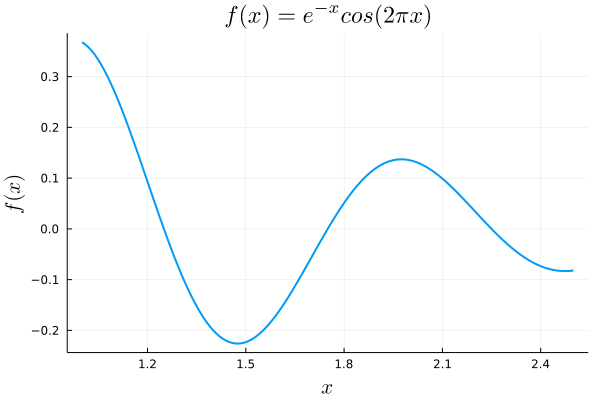

In [4]:
# Run me, don't change me. I will generate a plot for you. 
#
# Create a known function with no noise

x_actual = collect(1:0.01:2.5);
y_actual = cos.(2π * x_actual) .* exp.(-x_actual);
plot(x_actual, y_actual, title=L"$f(x) = e^{-x}cos(2\pi x)$", legend=false)
xlabel!(L"x")
ylabel!(L"f(x)")

In [5]:
?randn

search: randn randn! randstring lowrankdowndate lowrankdowndate!



```
randn([rng=GLOBAL_RNG], [T=Float64], [dims...])
```

Generate a normally-distributed random number of type `T` with mean 0 and standard deviation 1. Optionally generate an array of normally-distributed random numbers. The `Base` module currently provides an implementation for the types [`Float16`](@ref), [`Float32`](@ref), and [`Float64`](@ref) (the default), and their [`Complex`](@ref) counterparts. When the type argument is complex, the values are drawn from the circularly symmetric complex normal distribution of variance 1 (corresponding to real and imaginary part having independent normal distribution with mean zero and variance `1/2`).

# Examples

```jldoctest
julia> using Random

julia> rng = MersenneTwister(1234);

julia> randn(rng, ComplexF64)
0.6133070881429037 - 0.6376291670853887im

julia> randn(rng, ComplexF32, (2, 3))
2×3 Matrix{ComplexF32}:
 -0.349649-0.638457im  0.376756-0.192146im  -0.396334-0.0136413im
  0.611224+1.56403im   0.355204-0.365563im  0.0905552+1.31012im
```


Each of the yellow dots is a measurement that we will 
    use for building an approximation of the function f(x) 


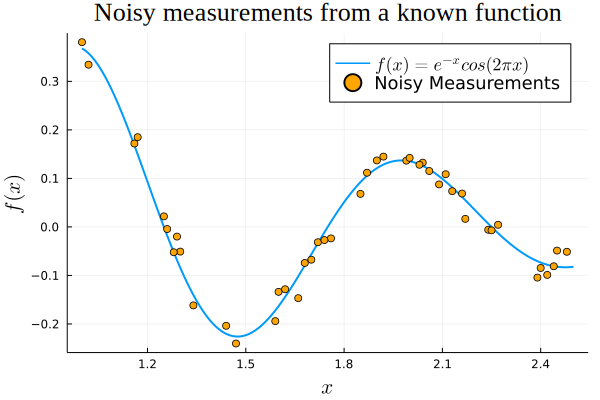

In [6]:
# Run me, don't change me. I will generate the following for you:
#     - x_measured a vector of real numbers of points where the function is "measured"
#     - y_measured a vector of real numbers of points corresponding to "noisy" measurements
#     - A plot with our function + the points we sampled from it with noise

# Randomly sample N points along the x axis
N = 50

# Allows us to get the same random numbers every time we run this cell
Random.seed!(12345678)

# We use unique because after flooring the numbers (rounding numbers to the nearest 
# integer less than or equal to the number), we may have repeated indices
idx = Int.(unique(floor.(rand(N) * length(x_actual))) .+ 1) # random indices
N   = length(idx);

x_measured = x_actual[idx]; # Training input

# Noise from a scaled normal distribution
y_measured = y_actual[idx] + 0.02 * randn(N)

println("Each of the yellow dots is a measurement that we will 
    use for building an approximation of the function f(x) ")

plot(x_actual, y_actual, title="Noisy measurements from a known function",
    label=L"$f(x) = e^{-x}cos(2\pi x)$", xlabel=L"$x$", ylabel=L"$f(x)$")
scatter!(
    x_measured, 
    y_measured, 
    c=:orange, # set the color
    label="Noisy Measurements", 
    legend=:best) # automatically use best location to place legend in graph

Now imagine that we were given the indicated noisy measurements (yellow dots) and we would like to fit a function to them. Here, in this toy example, we know what the function is, but in practice, all we know are the measured values! How can we go about finding a function that explains the data?

Let's start with trying to use a basis often used in the textbook, namely monomials (powers of x). Remember that the basis functions can themselves be nonlinear. It is only the way that we combine the functions together that needs to be linear (a linear combination). Follow this pipeline to solve a least squares problem using LU factorization as you will also find in Chapter 8 of our textbooks! 

[![image.png](https://i.postimg.cc/Sxx5Pw8V/image.png)](https://postimg.cc/8jxtJXZr)
<!-- [![Least-squares-LU.png](https://i.postimg.cc/bYFHD8rj/Least-squares-LU.png)](https://postimg.cc/MXVjNC1s) -->
<!-- [![QR-Axb-pipeline.png](https://i.postimg.cc/dtHdnyrV/QR-Axb-pipeline.png)](https://postimg.cc/kBSBgDT0) -->

### To efficiently solve for x in the pipeline, we create our function blocks for backward and forward subtitution, same as in homeworks!

In [7]:
# Run me, don't change me. I will create a forward substitution function and a backward substitution function 
# that you can apply to systems of linear equations with arising from an LU Factorization

#=
forwardsub(L, b)

It solves for x in an equation Lx = b, where L is lower triangular.
=#


function forwardsub(L, b)
    # Assert no entries in the diagonal of L
    # are 0 (or very close to 0)
    @assert minimum(abs.(diag(L))) > 1e-6
    # START of our computations
    n = length(b)
    x = Vector{Float64}(undef, n); #initialize an x vector of the correct size
    x[1] = b[1]/L[1,1] #find the first entry of x
    for i = 2:n #find every entry from the 2nd to the end
        x[i] = (b[i]- (L[i,1:i-1])'*x[1:i-1] )/L[i,i] 
        #notice that we used the transpose operator to get the row of L
    end
    # END of our computations. 
    return x
end

# Run me, don't change me. I will create a back substitution function that you can apply
# to systems of linear equations with an upper triangular "A" matrix, that we denote by U

#=
backwardsub(U, b)

It solves for x in an equation Ux = b, where U is upper triangular.
=#

function backwardsub(U, b)
    
    # Assert no entries in the diagonal of U
    # are 0 (or very close to 0)
    @assert minimum(abs.(diag(U))) > 1e-6
    
    n = length(b)
    x = Vector{Float64}(undef, n)

    x[n] = b[n] / U[n,n]
    for i = n-1:-1:1
        x[i] = (b[i] - (U[i,(i+1):n])' * x[(i+1):n]) ./ U[i,i]
    end
    
    return x    
end

backwardsub (generic function with 1 method)

To efficiently solve for x in the pipeline, we create our function blocks for backward and forward subtitution, same as in homeworks! 

**Your current objective:** find a set of coefficients $a_1$, $a_2$, $a_3$, $a_4$ such that for every measured point $x_i$, our model produces a prediction or output as close to the actual $y_i$ value as possible. The error between our model prediction and our actual value is $e_i = y_i - \hat{y}_i$.

$$\hat{y} = a_1 + a_2 x + a_3 x^2 + a_4 x^3 $$

We refer to our coefficients collectively as $a_{star} = [a_1, a_2, a_3, a_4]$. As we will see in the next couple of cells, the use of monomials as basis functions will not be a great design choice here. However, we use it for the purpose of illustrating the value of radial basis functions. 

## Task 1: Construct a Regressor Matrix (3 points)

With the model described above, we can form a set of linear equations where each equation is formed by evaluating the $x_i$ value of our measurement to obtain a predicted $\hat{y}_i$ value.

\begin{align*}
\hat{y}_1 &= a_1 + a_2x_1 + a_3x_1^2 + a_4x_1^3 \\
\hat{y}_2 &= a_1 + a_2x_2 + a_3x_2^2 + a_4x_2^3 \\
&~~\vdots \\
\hat{y}_k &= a_1 + a_2x_k + a_3x_k^2 + a_4x_k^3 \\
&~~ \vdots \\
\hat{y}_N &= a_1 + a_2x_N + a_3x_N^2 + a_4x_N^3
\end{align*}

With our linear equations written out, we can now write the set of linear equations succinctly as $\hat{Y} = \Phi a$. 

## For Task 1, you will compose the code necessary to construct the regressor matrix  $\Phi$ for our assumed model. __Hint:__ Since our model has 4 coefficients, the size of $\Phi$ will be N x 4 where N is the number of measurements we have taken. 

## We first remind you how in lecture we constructed the regressor matrix $\Phi$ column-by-column and then we have you do it row-by-row. Both methods are common in engineering practice.

In [8]:
# Run me and note the size of x_measured
length(x_measured)

44

In [9]:
# In HW, Lab, and Lecture, we have usually constructed the regressor matrix columnwise, as follows
#
# monomial basis elements = [1 x x² x³]
N = length(x_measured)
# regressor matrix by columns
Phi_example=[ones(N,1) x_measured x_measured.^2 x_measured.^3]
#

44×4 Matrix{Float64}:
 1.0  2.39  5.7121  13.6519
 1.0  1.87  3.4969   6.5392
 1.0  2.13  4.5369   9.6636
 1.0  1.47  2.1609   3.17652
 1.0  1.0   1.0      1.0
 1.0  2.09  4.3681   9.12933
 1.0  1.02  1.0404   1.06121
 1.0  2.16  4.6656  10.0777
 1.0  2.04  4.1616   8.48966
 1.0  1.44  2.0736   2.98598
 1.0  2.03  4.1209   8.36543
 1.0  2.17  4.7089  10.2183
 1.0  1.29  1.6641   2.14669
 ⋮                  
 1.0  2.25  5.0625  11.3906
 1.0  1.68  2.8224   4.74163
 1.0  1.66  2.7556   4.5743
 1.0  2.48  6.1504  15.253
 1.0  2.45  6.0025  14.7061
 1.0  1.25  1.5625   1.95312
 1.0  2.42  5.8564  14.1725
 1.0  1.74  3.0276   5.26802
 1.0  1.62  2.6244   4.25153
 1.0  1.3   1.69     2.197
 1.0  1.28  1.6384   2.09715
 1.0  2.06  4.2436   8.74182

In [10]:
# For the project, we want you to build the regressor matrix row-by-row. You will need a for loop 
# The monomial basis is still [1 x x² x³]

N=length(x_measured)
Phi=zeros(N,4)

#
# Write a for loop that builds the regressor matrix row by row.
# There should be N rows, where N is defined above.
#
# your code here

for row in 1:N
    Phi[row,1] = 1
    Phi[row,2] = x_measured[row]
    Phi[row,3] = x_measured[row].^2
    Phi[row,4] = x_measured[row].^3
end


# As a reminder, 
A = Phi'*Phi 
# this is how you do LU Factorization of the matrix ``Phi'*Phi`` in Julia
F = lu(A)
L = F.L
U = F.U
P = F.P

# Display L, U and P to verify sizes
@show size(Phi);
@show size(L);
@show size(U);
@show size(P);



size(Phi) = (44, 4)
size(L) = (4, 4)
size(U) = (4, 4)
size(P) = (4, 4)


In [11]:
# friendly check
# if the value of is_it_correct_checkN is "Yes", then your answer may be correct. 
# If the value of is_it_correct_checkN is "No", then your answer is wrong

is_it_correct_check1 = (norm(Phi-Phi_example) < 1e-8) ? "Yes" : "No" 

@show is_it_correct_check1;

is_it_correct_check1 = "Yes"


In [12]:
# Autograder cell

## Least Squares LU Pipeline (1 point)

In [13]:
# We continue our illustration of regression, where the least squared error fit
# is determined via the LU Factorization. Run the cell, don't change anything. 
# Pay attention, though!
#
# Pipeline for Least Squares using LU factorization
b = Phi' * y_measured
y = forwardsub(L, P*b)
a_star = backwardsub(U, y)

# Save the coefficients to be used later
a_monomial = copy(a_star)

# Let's see the cofficients for our monomial fit model 
@show a1 = a_star[1];
@show a2 = a_star[2];
@show a3 = a_star[3];
@show a4 = a_star[4];

a1 = a_star[1] = 8.750516208925735
a2 = a_star[2] = -15.629061934871846
a3 = a_star[3] = 8.960324240424335
a4 = a_star[4] = -1.656567935814787


In [14]:
# Autograder cell, just checking if you ran everything fine 
@assert isapprox(a_monomial, [8.750516208925735, -15.629061934871846,8.960324240424335, -1.656567935814787], atol = 0.001)

## Let's now use your regressed coefficients a_star to be build a scalar-valued (i.e., not a vector) function based on the monomials, $1, x, x^2, x^3$. Remember that you are fitting a function to data. Hence, the result of your regression work with monomials is a polynomial approximation to our data.


In [15]:
# Build a function based on your regressed monomial coefficients.
# Your function only needs to work for x a scalar value
#
# Hint, later in the notebook, the problem is essentially solved for you!
#
function yHatMonomials(x,a=a_star)
    # x is a scalar value (real number)
    # a is a vector of parameters for the polynomial
    # yHat is the polynomial approximation to the data at the point x
    # your code here
    yHat = a[1] + a[2]*x + a[3]*(x^2) + a[4]*(x^3)
    return yHat    
end

yHatMonomials (generic function with 2 methods)

In [16]:
# friendly check
# if the value of is_it_correct_checkN is "Yes", then your answer may be correct. 
# If the value of is_it_correct_checkN is "No", then your answer is wrong

is_it_correct_check1 = ((yHatMonomials(-1) - 34.9964703200367) < 1e-8) ? "Yes" : "No" 
is_it_correct_check2 = ((yHatMonomials(2) - 0.08114581436108992) < 1e-8) ? "Yes" : "No" 
is_it_correct_check3 = (norm(yHatMonomials.([1; 2]) -[0.42521057866344014; 0.08114581436108992]) < 1e-8) ? "Yes" : "No" 

@show is_it_correct_check1;
@show is_it_correct_check2;
@show is_it_correct_check3;

is_it_correct_check1 = "Yes"
is_it_correct_check2 = "Yes"
is_it_correct_check3 = "Yes"


Finally, now that we have our weights for the monomial basis elements, let's check the quality of our fit. A way to quantify how well our model fits the data is to calculate the total squared fitting error. We will calculate our error by comparing how well our model predicts the values we actually measured (remember, we wouldn't know the actual function in practice). 

We define the fitting error $E_{tot}$ below where $y_i$ is the true value obtained from our known function at $x_i$, and $\hat{y}_i$ is the ouput of our model after evaluating it at $x_i$.

$$E_{tot} = \sum_{i=1}^{N}(e_i)^2 = e^\intercal e = (\hat{y}_i - y_i)^\intercal(\hat{y}_i - y_i) = ||\hat{y}_i - y_i||^2_2$$


The next cell provides us a small helper function to calculate this error.

In [17]:
# Run me, don't change me! I create a function that
# helps to calculate the fitting error of our
# monomial model

#=
error_monomial_fit(a, X)

Calculates and returns the error E_tot defined as:

            E_tot = Σ(yhat_i - y_i)^2

between the monomial model and the actual function
=#
function error_monomial_fit(X,a=a_star)
    #This function accepts X as a column vector
    
    @assert size(a,1) == 4
    
    # Calculate the value of the model: y_hat = a₁ + a₂x + a₃x^2 + a₄x^3
    y_hat = a[1] .+ a[2]*X + a[3]*X.^2 + a[4]*X.^3

    # Return the total squared error E_tot
    return (y_measured - y_hat)' * (y_measured - y_hat)
end

error_monomial_fit (generic function with 2 methods)

Monomial Fitting Error: 0.15928000934452397


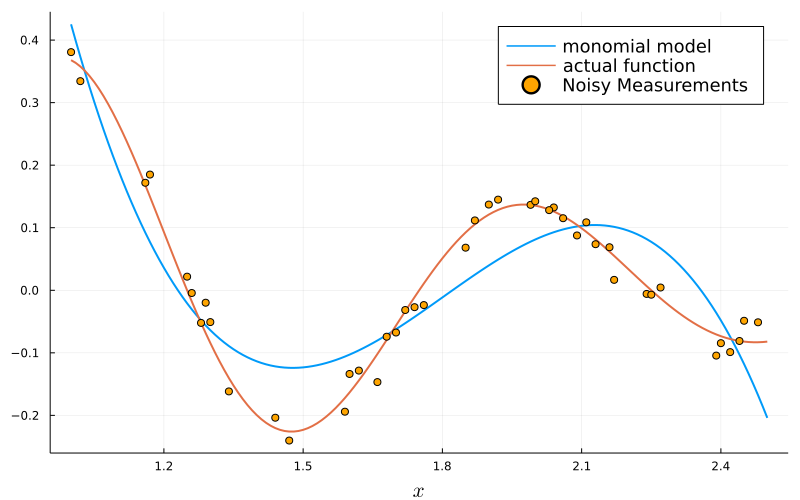

In [18]:
# Run me, don't change me! We illustrate here how to generate 
# a plot of the estimated function and report the fitting error.
#
# We use the same x points we used for drawing our original 
# function to draw our regressed function

y_hat = yHatMonomials.(x_actual)

# Calculate and display the fitting error
etot = error_monomial_fit(x_measured)
println("Monomial Fitting Error: ", etot)

plot(x_actual, y_hat, label="monomial model", xlabel=L"$x$")
plot!(x_actual, y_actual, label="actual function")
scatter!(x_measured, y_measured, c=:orange, label="Noisy Measurements", 
    legend=:best, size=(800,500))

### While the general shape seems to be identified, the crests in the plot do not match well and we can see that, if we were to extend the x axis in either direction, the two curves would diverge significantly. 

## The source of the problem is the use of the monomials, which, being powers of x, blow up as x gets large. This turns out to be very incovenient when doing regression problems.

### Let's plot the monomial functions individually and get a feel for them. As you move through the notebook, the goal will be to arrive at a model that will produce a lower fitting error than the one above based on monomials.

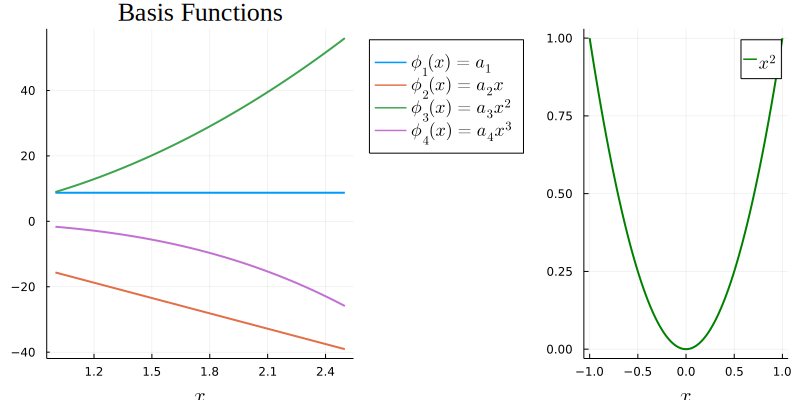

In [19]:
#Run me, don't change me !
#
# I create two plots. The first plot shows a line for each of the 4 monomials 
# in our model. The second plot shows a picture of x^2 to use as a reference.

l = @layout [a{0.7w} b{0.3w}]
p1 = plot(x_actual, a1*ones(length(x_actual)), label=L"$\phi_1(x) = a_1$")
plot!(p1, x_actual, a2*x_actual, label=L"$\phi_2(x) = a_2 x$")
plot!(p1, x_actual, a3*x_actual.^2, label=L"$\phi_3(x) = a_3 x^2$")
plot!(p1, x_actual, a4*x_actual.^3, label=L"$\phi_4(x) = a_4 x^3$",
    legend=:outertopright)
xlabel!(L"$x$")
title!("Basis Functions")

x_sq = collect(-1:0.01:1)
p2 = plot(x_sq, x_sq.^2, label=L"x^2",color=:green)
xlabel!(L"$x$")
plot(p1, p2, layout=l, size=(800,400))

What are some things you might notice about each of the individual monimals you've plotted? If someone asked you to describe the shape of the $x^2$ you might say that it is bowl shaped, as shown to the right. However, in the image to the left, we see only a portion of a _really_ big bowl. One of the issues of using the monomial basis functions is that if we take $x^2$ for example, regression tries to fit it to all the measurements. What if we could have it just fit ONLY the measurements near the bowl shape at $x$=1.5 in the orignal (actual) function. **Said another way, what if we could locally  fit the basis functions to certain parts of the data?**


## The Radial Basis Function


$$f(x; x_c, s) = exp(\frac{-\|x-x_c\|^2}{2s^2})$$

The equation above is the formula for a generic Radial Basis Function (RBF). $x$ and $x_c$  are vectors in $\mathbb{R}^n$ and $s$ is a positive scalar. Both $x_c$ and s are known before evaluating the function and are said to parameterize the function. Just as $y=2x$ and y=$-3x$ are both equations for lines but the value of the slope changes the steepness of the line, we will find that our radial basis function always has a bell-shaped curve that changes its look based on the values of $x_c$ and $s$. In particular, $x_c$ determines the **center** of the function and s determines its **width**.

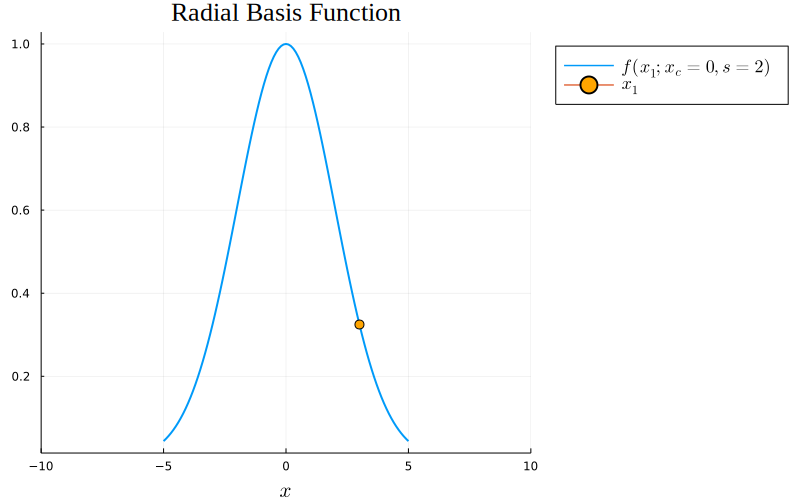

In [20]:
# For this cell, try out different values for each of the
# three variables listed below with the suggested range for 
# each variable in the comments. The cell will display the 
# RBF function.

## EDIT ##
x1 = 3  # Try values between [-5, 5]
xc = 0  # Try values between [-5, 5]
s = 2   # Try values between [0.1, 2]
## EDIT

# The radial basis function, vectorized!
# For x a column vector, xc a scalar, and s a scalar, the function
# returns a column vector of the same size as x
rbf(x, xc, s) = exp.(-(x.-xc).^2 / (2*s^2))

x = collect(-5:0.1:5) .+ xc
y = rbf(x, xc, s) 
    
plot(x, y, xlabel=L"$x$", label="\$f(x_1;x_c=0,s=$s)\$",
    title="Radial Basis Function", xlims=(-10,10))
plot!([x1], [rbf(x1, xc, s)], marker=:orange, markersize=5, 
    label=L"$x_1$", legend=:outertopright, size=(800,500))

Take a few minutes to understand how changing each input to the function affects its graph. As you play around with the inputs you should notice the following:

* $x$: as $x$ gets further and further in either direction away from $x_c$, the value of the function becomes smaller. It is the largest when $x$ is exactly $x_c$. This makes sense because when we look at the numerator in the exponent of our RBF, $\|x-x_c\|^2$ just represents the norm (distance) between two vectors. However, because we are negating the power in the function ($\exp(-...)$), large norms lead to small ouptut values.

* $x_c$: changes where the peak of the bell curve lies. We can think of this as the function's center.

* $s$: changes how narrow or wide our function is


## Task 2: Using Radial Basis Functions  (RBFs) (2+2 points)

## Part A: Fitting By Hand on RBFs (2 points)

In the last set of cells, we looked at how the inputs of the RBF change the shape of the function. In this task, we explore trying to fit our original real-valued function $f(x) = e^{-x}cos(2\pi x)$ with two RBFs and a constant. We can write our model as follows:

$$\hat{y} = a_0 + a_1 f(x; x_{c_1}, s) + a_2 f(x; x_{c_2}, s)$$

Note that in this formulation, the width parameter $s$ is shared between both RBFs. Typically, when using RBFs, there will be one width parameter shared among all of the basis functions. For the rest of this project, we will do so as well. In the next two cells, we provide two helper functions to plot our model and calculate the fitting error with our two-RBF model.


In [21]:
# Run me, don't change me. I will create a function
# that will plot our 2 RBF models along with our
# original function using the parameters provided

function plot_2rbf_model(f)    
    # Calculate the value of the model: y_hat = a₁f(x; xc1, s) + a₂f(x; xc2, s)
    # at each data point val in x_actual and arrange it as a vector
     y_hat = f(x_actual)    
     plot(x_actual, y_actual, title="Partial Data Fit", line=:dash,
        label=L"$f(x) = e^{-x}cos(2\pi x)$", xlabel=L"$x$", ylabel=L"$f(x)$")
    plot!(x_actual, y_hat, label="\$$a0 + $a1 f(x_1;x_c=$xc1,s=$s) + $a2 f(x;x_c=$xc2,s=$s)\$")
    scatter!(x_measured, y_measured, c=:orange, label="Noisy Measurements", 
        legend=:best, size=(800,500)) 
end

plot_2rbf_model (generic function with 1 method)

In [22]:
# Run me, don't change me. I will create a function
# that will calculate the total error between our
# model predicted values and the actual measurements

#=
error_2rbf_fit(a1, xc1, a2, xc2, s, x)

Calculates and returns the error E_tot defined as:

            E_tot = Σ(yhat_i - y_i)^2

when x is a vector
=#

function error_2rbf_fit(a0, a1, xc1, a2, xc2, s, x)
    
    # Calculate the value of the model: y_hat = a₁f(x; xc1, s) + a₂f(x; xc2, s)
    # at each data point val in x and arrange it as a vector
    y_hat = [a0 + a1 * rbf(xval, xc1, s) + a2 * rbf(xval, xc2, s) for xval in x]
    # the "for xval in x" creates y_hat as a column vector (N x 1 matrix)
    # where N = length(x). 
    return (y_measured - y_hat)' * (y_measured - y_hat)
end

error_2rbf_fit (generic function with 1 method)

For this task, you will tune by hand 5 parameters to minimize the fitting error $E_{tot}$ of our model. The parameters $a_1$ and $a_2$ are the coefficients of our model, $xc1$ and $xc2$ are the centers of our RBFs and $s$ is the shared width parameter. The constant term/bias is set to $a_0 = 0.05$.

## Because we are only using two RBFs and are tuning the parameters by hand, the goal is to identify a parameter set that produces a total error that is less that 0.5.

To start off, it is suggested to fit one RBF at a time. Set the coefficient $a_2$ to 0 if it is not 0 by default and adjust the parameters $a_1$, $xc1$, $s$ to approximately fit one of the two humps in the function. Once that's done, begin to modify $a_2$ and $xc2$. As you start fitting the second RBF, you may want to revisit some of your values for $s$, $a_1$, and $xc2$.

Monomial Fitting Error: 0.15928000934452397
2 RBF Fitting Error   : 0.48957723099271167
 
Good enough! You pass the test! It is not worth achieving a lower error by hand.


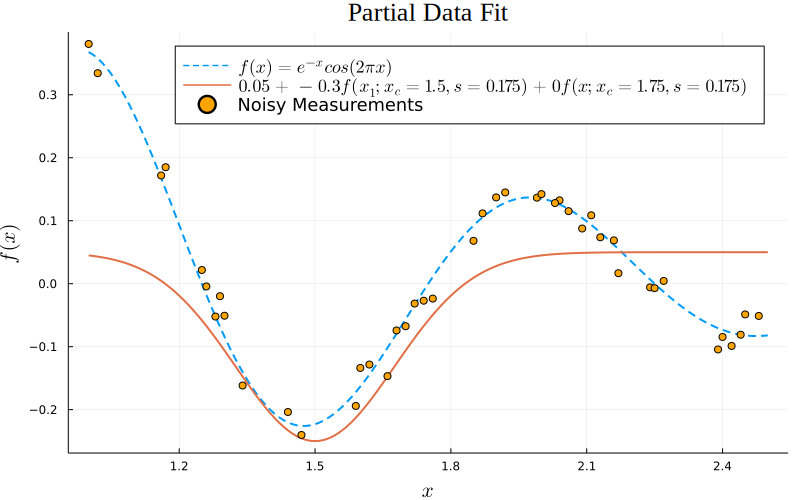

In [23]:
# Modify this cell. In this cell you will tune the values in
# the edit section to fit two RBFs to our original function
# Each time you run this cell will plot the model defined
# by the parameters as well as display the fitting error

# IGNORE THE YOUR CODE HERE COMMENT AND REMOVE THE ERROR EXCEPTION. 
# As suggested your task is to hand tune the values, which follows this prompt!
# your code here

# ######     EDIT     ######
a1  = -0.3  # Try values in between [-1, 1] 
xc1 = 1.5  # Try values in between [1, 2.5]
s   = 0.175  # Try values in between [0, 0.3]
xc2 = 1.75  # Try values in between [1, 2.5]
a2  = 0    # Try values in between [-1, 1]
a0 = 0.05  # Don't change this value. We already tuned it for you! 
# ######     EDIT     ######

# Display error
etot_2rbf = error_2rbf_fit(a0, a1, xc1, a2, xc2, s, x_measured)
etot_monomials = error_monomial_fit(x_measured,a_monomial)
println("Monomial Fitting Error: ", etot_monomials)
println("2 RBF Fitting Error   : ", etot_2rbf)
println(" ")
if etot_2rbf < 0.5
    println("Good enough! You pass the test! It is not worth achieving a lower error by hand.")
else
    println("Keep trying. Be systematic on how you go about adjusting the values a1 xc1 s a2 xc2")
end

# Plot model
y_rbf(x) = [a0 .+ a1 * rbf(x, xc1, s) .+ a2 * rbf(x, xc2, s)]
plot_2rbf_model(y_rbf)

In [24]:
# Autograder cell

### Congratulations! You have just fit using RBFs and we hope you can see that with just two bases that we are already getting a significantly better fit in the middle portion of the x-axis. 

### At the moment, with just two basis, the total fitting error is still many times larger due to the deviation at the tails, but as we add more basis we can begin to get a closer fit at the ends of the function as well. A lot of the magic of the fit comes from the fact that values evaluated far away from the center of a RBF are very close to 0. This makes RBFs very nice to use in our linear model. 

### However, you still may have needed to have gone back and adjusted the parameters of the first RBF once you started adjusting the parameters of the second. Now that we have an understanding of the benefits of using RBFs for fitting, let's see if we can use our least squares pipeline to find a model and a set of coefficients that has a lower fitting error than our monomial model.


## Part B: Fitting using Least Squares and RBFs (2 points)


To start using more RBFs in our model, let's first expand our model and also add back the constant term. M represents the number of RBFs we decide to use in our model.

$$\hat{y} = a_1 + a_2 f(x; x_{c_1}, s) + a_3 f(x; x_{c_2}, s) + ... + a_{M+1} f(x; x_{c_M}, s)$$

Looking back up top to the least squares LU factorization pipeline, the first step we need to do is construct the regressor matrix ($\Phi$). When using the monomials, $\Phi$ looked like so:

$$
\begin{equation} \label{eq:monomial_mat_form}
    \underbrace{
    \begin{bmatrix}
    \hat{y}_1 \\
    \hat{y}_2 \\
    \vdots \\
    \hat{y}_N
    \end{bmatrix}}_{\hat{Y}}
    =
    \underbrace{
    \begin{bmatrix}
    1 & x_1 & x_1^2 & x_1^3 \\
    1 & x_2 & x_2^2 & x_2^3 \\
    \vdots & \vdots & \vdots & \vdots \\
    1 & x_N & x_N^2 & x_N^3
    \end{bmatrix}}_{\Phi}
    \underbrace{
    \begin{bmatrix}
    a_1 \\
    a_2 \\
    a_3 \\
    a_4
    \end{bmatrix}}_{\alpha}
\end{equation}
$$

With our RBFs, a single row in our $\Phi$ matrix can now be determined by following the below construction of a row where $x_i$ is the ith measurement out of N total measurements, $s$ is the shared RBF width parameter (also sometimes refered to by the name kernel width) and $x_{c_1}$ through $x_{c_m}$ are M different basis centers. The next few cells provide some useful helper functions that we will use in our pipeline.

$$
\begin{bmatrix}
    1 & f(x_i;x_{c_1},s) & f(x_i;x_{c_2},s) & ... & f(x_i;x_{c_M},s) \\
\end{bmatrix}
$$

In [25]:
# Run me, don't change me. I will create a function THAT
# will be helpful in assembling our Φ matrix assuming
# our model is a linear combination of RBFs

#=
function calc_phi_row(x, centers, s)

Returns a single row in the regressor matrix, Φ 

Inputs:
    xᵢ      - the value of the i-th measurment x
    centers - an Mx1 vector holding the centers of the determined RBFs
    s       - the shared kernel width (RBF width)
=#

function calc_phi_row(xᵢ, centers, s)
    # xᵢ is a scalar
    # centers is a vector of centers for the rbf basis elements
    # s is the scale value
    NumBasisElements = length(centers) + 1
    # plus one above because we also include a constant
    phi_row = zeros(1,NumBasisElements)
    phi_row[1] = 1    
    for i = 2:NumBasisElements
        phi_row[i] = rbf(xᵢ, centers[i-1], s)
    end    
    return phi_row
end

calc_phi_row (generic function with 1 method)

## Build the regressor matrix row by row using the function ```calc_phi_row(xᵢ, centers, s)``` and a for loop

In [55]:
# Create a function that returns the regressor matrix Φ 
# based on our model using RBFs as basis functions

#=
function regressor_matrix()

Returns the regressor matrix Φ

Inputs:
    X       - a Nx1 vector holding the X value of all the measurements
    centers - a Mx1 vector holding the centers of the determined RBFs
    s       - the shared kernel width (RBF width)
=#

function regressor_matrix(X, centers, s)
    # X is a vector of points in R
    # centers is a vector of centers for the rbf basis elements
    # s is the scale value    
    N = length(X)
    M = length(centers)
    Phi = Array{Float64, 2}(undef, N, M+1)
    # your code here
    for i in 1:N
        x = calc_phi_row(X[i],centers,s)
        for j in 1:(M+1)
            Phi[i,j] = x[j]
        end

    end
    
    return Phi
end

regressor_matrix (generic function with 1 method)

In [56]:
PhiTest=regressor_matrix(x_measured, [1;2;3], 0.15)[3,:]

4-element Vector{Float64}:
 1.0
 4.749553688741421e-13
 0.6869075574573883
 4.9564053191724624e-8

In [57]:
# friendly check
# if the value of is_it_correct_checkN is "Yes", then your answer may be correct. 
# If the value of is_it_correct_checkN is "No", then your answer is wrong
PhiTestRow=regressor_matrix(x_measured, [1;2;3], 0.15)[3,:]

is_it_correct_check1 = ( norm(PhiTestRow -[1.0; 4.749553688741421e-13; 0.6869075574573883; 4.9564053191724624e-8]) < 1e-8) ? "Yes" : "No" 

@show is_it_correct_check1;

is_it_correct_check1 = "Yes"


In [58]:
# Run me, don't change me. 

#=
function least_squares_lu(A::Array{Float64,2},  b::Array{Float64,1})

Solves for x in Ax = b using the LU factorization. Returns x.
=#
function least_squares_lu(A::Array{Float64,2},  b::Array{Float64,1})
    F = lu(A)
    L = F.L
    U = F.U
    P = F.P
    y = forwardsub(L, P*b)
    x = backwardsub(U, y)
    return x   
end

least_squares_lu (generic function with 1 method)

## Now that we have some helper functions, let's see how well we can fit our samples using radial basis functions and the least squares pipeline to calculate the optimal coefficients for our model. The goal of this task is to produce a fitting error that is less than the error we had with our monomial model. 

# In this task, you will play around with the one parameter,  $M$, which you can set in the next cell. $M$ represents the number of radial basis functions in our model. We give you a good $s$ value since it may be difficult to tune. Do not change it.  $s$ represents the width each RBF will use. 

## In the next cell, we use $M$ to select our basis centers and display them in a plot. The centers should be selected in the domain (x range) of the data, so we randomly select some of the measured x values to use as our centers. As we saw when we just used 2 RBFs, we need to place enough RBFs to sufficiently cover the domain of the data (so our model fits the tails of the function just as well as the middle of it). One way to achieve this is to randomly select values from the data to use as basis centers. Because $\texttt{x_measured}$ is not sorted, when we select indices below, the centers will seem to appear at random.

Centers at x = [2.39, 2.03, 1.59, 2.25, 2.06]


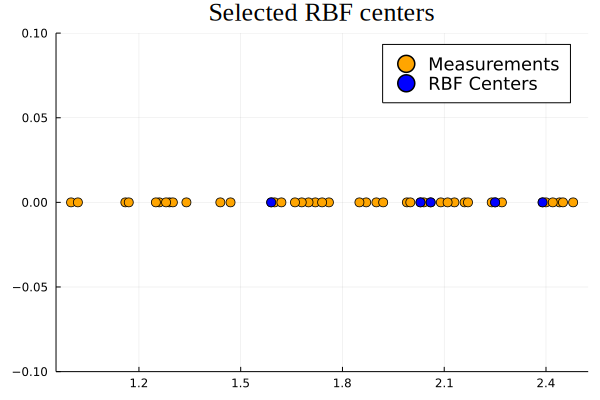

In [66]:
# Modify this cell by changing the number of basis functions, M, 
# and the width, s.

# IGNORE THE YOUR CODE HERE COMMENT AND REMOVE THE ERROR EXCEPTION. 
# As suggested, your task is to play around with parameters M and s,
# the code for which follows this prompt!
# your code here

s = 0.25
## Edit ##
M = 5 # To be clear, 2 is too small and 10 is too big! 
## Edit ##

# If we have N measurements, select M of them evenly spaced by index from 1 to N
# Note that because the measurements are not sorted as you change M, they
# will appear to be selected at random from x_measured
center_indices = Int.(floor.(collect(range(1, N, length=M))))

# Creating a vector like this is known as using list comprehension
# Read it as - for every element i in center_indices get the ith value in x_measured
centers = [x_measured[i] for i in center_indices]
println("Centers at x = ", centers)

# Visually see selected RBF centers
scatter(x_measured, zeros(N,1), markersize=5, c=:orange, label="Measurements", title="Selected RBF centers")
scatter!(centers, zeros(M,1), markersize=5, c=:blue, label="RBF Centers", legend=:best)
ylims!((-0.1,0.1))

**Note:** Some combinations of $M$ and $s$ result in a $U$ matrix in the backwardsub function whose columns are not linearly independent. In this case, you will be met with an assertion error that checks if any of the diagonal elements are close to 0: $\texttt{minimum(abs.(diag(U))) > 1.0e-6}$. 

**This happens when some basis centers are really close to one another or the value of $s$ is too large.** Consider changing the value of $M$ to obtain a different set of centers.

In [67]:
# Use the LU-based least squares pipeline to fit your selected number of
# RBF functions to y_measured. 
#

Phi = regressor_matrix(x_measured, centers, s)
# Call your computed coefficients  a_star
# a_star =
# your code here

A = Phi'*Phi 
print("Phi size: ",size(A))
b = Phi'*y_measured
print("b size: ",size(b))
a_star = least_squares_lu(A,b)


Phi size: (6, 6)b size: (6,)

6-element Vector{Float64}:
   0.3475244316237257
  -1.579294157041292
   9.348622298828932
  -0.7801175707987555
   2.7964717260400476
 -10.827268694178482

In [68]:
# Run me, don't change me. I do the following:
# (a) build a function to evaluate your regressed function at an arbitray value of x. You will need to do this in 
#    part 2 of the project, so pay attention
# (b) evaluate it at the points x_actual and the points x_measured
# (c) compute the total squared fitting error
#
# The function
f_hatRBF(x)=(calc_phi_row(x, centers, s)*a_star)[1] 
# In the above function, note that calc_phi_row(x, centers, s)*a_star is
# a 1 x 1 matrix and thus you need to extract its entry (or contents)
# Hence, the [1]. See the Lab Manual for a discussion of 1 x 1 matrices 
#
# which I now evalue at the points x_actual
y_hatRBF=zero(x_actual) # create a vector of the correct size,
#
for i in 1:length(x_actual)
   y_hatRBF[i] = f_hatRBF(x_actual[i])
end
# 
# which I now evalue at the points x_measured
y_estRBF=zero(x_measured) # create a vector of the correct size,
#
for i in 1:length(x_measured)
   y_estRBF[i] = f_hatRBF(x_measured[i])
end
# 
etot_rbf =  (y_measured - y_estRBF)' * (y_measured - y_estRBF)

0.0487866934994418

In [69]:
# friendly check
# if the value of is_it_correct_checkN is "Yes", then your answer may be correct. 
# If the value of is_it_correct_checkN is "No", then your answer is wrong 

is_it_correct_check1 = (etot_rbf < 0.1) ? "Yes" : "No" 

@show is_it_correct_check1;

is_it_correct_check1 = "Yes"


Monomial Fitting Error: 0.15928000934452397
RBF Fitting Error     : 0.0487866934994418


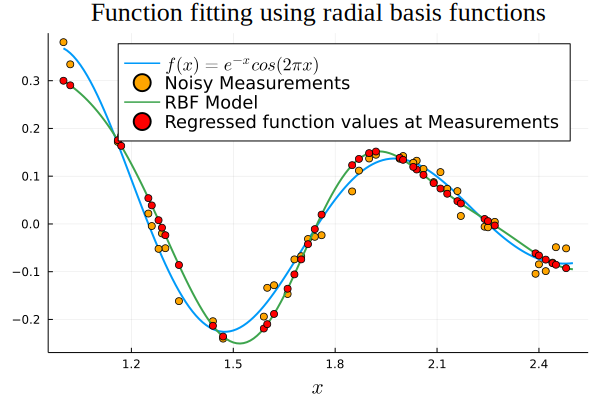

In [70]:
# Run me, don't change me! I compare the monomial
# fitting error with the error of our new RBF model
# and additionally display the fit

# Calculate and display the fitting error
etot_monomial = error_monomial_fit(x_measured, a_monomial)
println("Monomial Fitting Error: ", etot_monomial)
println("RBF Fitting Error     : ", etot_rbf)

# Plot the results
plot(x_actual, y_actual, label=L"$f(x) = e^{-x}cos(2\pi x)$", xlabel=L"$x$",)
scatter!(x_measured, y_measured, c=:orange, label="Noisy Measurements")
plot!(x_actual, y_hatRBF, label="RBF Model")
scatter!(x_measured, y_estRBF, c=:red, label="Regressed function values at Measurements", legend=:best)
title!("Function fitting using radial basis functions")

In [71]:
# Autograder cell

## Reflection


We have seen in this notebook that we can use radial basis functions to create a smooth fit. In project 2, instead of taking data and fitting a line (1D), we attempt to take 2D data and fit a surface to it. Spend some time thinking about what the parameters of the radial basis function, specifically what  𝑥𝑐  and  𝑠  represent, when the problem is extended into 2D.

# If you have completed this part, go ahead and hit the submit button. Remember, you can submit as many times as you want. We grade the last submission. 